In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.nn import GRUCell

import torchvision
import torchvision.transforms.functional as F
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import make_grid
from torchvision.ops import sigmoid_focal_loss
from torchvision.transforms.functional import convert_image_dtype

import pl_bolts
from pl_bolts.models.vision import UNet

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

import torchmetrics as tm

from torchinfo import summary

import os

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

# 1. Preparation

## 1.1 DataModule

In [3]:
batch_size = 8
num_workers = 4

In [4]:
class RoadSatelliteModule(pl.LightningDataModule):
    def prepare_data(self):
        self.train_images = self.read_images('train/images/', ImageReadMode.RGB)
        self.train_masks = self.read_images('train/groundtruth/', ImageReadMode.GRAY)
    
        for i, train_mask in enumerate(self.train_masks):
            self.train_masks[i][self.train_masks[i] > 0] = 1
            
        self.train_zip = list(zip(self.train_images, self.train_masks))
        
        self.test_images = self.read_images('test/', ImageReadMode.RGB)
        
    def setup(self, stage=None):
        if stage in (None, 'fit'):
            train_length = int(len(self.train_zip) * 0.8)
            valid_length = len(self.train_zip) - train_length

            self.train_data, self.valid_data = random_split(self.train_zip, [train_length, valid_length])
            
        if stage in (None, 'test'):
            self.test_data = self.test_images
            
    def train_dataloader(self):
        return DataLoader(
            self.train_data, 
            num_workers=num_workers,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.valid_data, 
            num_workers=num_workers,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True
         )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_data, 
            num_workers=num_workers,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True
        )
    
    def read_images(self, data_dir, read_mode):
        return [read_image(data_dir + file, read_mode) for file in os.listdir(data_dir)]

In [5]:
road_data = RoadSatelliteModule()

In [6]:
road_data.prepare_data()
road_data.setup()

## 1.2 Inspect data

In [7]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [8]:
seg_images = [draw_segmentation_masks(train_pair[0], train_pair[1].bool()) for train_pair in road_data.train_zip]

In [9]:
#for seg_image in seg_images:
#    show_image(seg_image)

# 2. System

In [10]:
class SemanticSegmentationSystem(pl.LightningModule):
    def __init__(self, model: nn.Module, datamodule: pl.LightningDataModule, lr: float = 1e-3, batch_size: int = batch_size):
        super().__init__()
        
        self.model = model
        self.datamodule = datamodule
        
        self.lr = lr
        self.batch_size = batch_size

    def training_step(self, batch, batch_idx):
        X, y = batch
        
        X = X.float()
        y = y.float()
        
        y_pred = self.model(X)
       
        loss = sigmoid_focal_loss(y_pred, y, reduction='mean')
        
        self.log('training_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
                
        X = X.float()
        y = y.int()
        
        y_pred = self.model(X)
        y_sig = torch.sigmoid(y_pred)
       
        metric = tm.functional.accuracy(y_sig, y, average='samples')
        
        self.log('validation_metric', metric)
        
        return metric
    
    def test_step(self, batch, batch_idx):
        X, _ = batch
        
        return self.model(X)
    
    @torch.no_grad()
    def visualize_results(self):
        Xs, ys = next(iter(self.val_dataloader()))
                
        y_preds = torch.sigmoid(self.model(X.float()))
        
        for y_pred in y_preds:
            show_image(y_pred)
           
    @torch.no_grad()
    def visualize_results_overlay(self):
        Xs, ys = next(iter(self.val_dataloader()))
                
        y_preds = torch.sigmoid(self.model(Xs.float()))
        
        pred_zip = list(zip(Xs, y_preds))
        
        seg_images = [draw_segmentation_masks(train_pair[0], train_pair[1].round().bool(), colors=['#00ff00']) for train_pair in pred_zip]
        
        for seg_image in seg_images:
            show_image(seg_image)
            
    def train_dataloader(self):
        return self.datamodule.train_dataloader()

    def val_dataloader(self):
        return self.datamodule.val_dataloader()

    def test_dataloader(self):
        return self.datamodule.test_dataloader()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=2)
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'validation_metric'
        }

# 3. Model

In [11]:
class SDNCell(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.gru = GRUCell(input_size=3*num_features, hidden_size=num_features)

    def forward(self, neighboring_features, features):
        """ Update current features based on neighboring features """
        return self.gru(torch.cat(neighboring_features, dim=1), features)


class _CorrectionLayer(nn.Module):

    def __init__(self, num_features, dir=0):
        super().__init__()
        self.num_features = num_features
        self.cell = SDNCell(num_features)
        if dir == 0:
            self.forward = self.forward0
        elif dir == 1:
            self.forward = self.forward1
        elif dir == 2:
            self.forward = self.forward2
        else:
            self.forward = self.forward3
        self.zero_pad = None

    def _get_zero_pad(self, batch, device):
        if self.zero_pad is None or self.zero_pad.shape[0] != batch:
            self.zero_pad = torch.zeros((batch, self.num_features, 1), device=device)  # no grad ??
        return self.zero_pad

    def forward0(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(1, dim):
            neighboring_features = torch.cat([zero_pad, features[:, :, :, d - 1], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, :, d] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, :, d].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward1(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(dim - 2, -1, -1):
            neighboring_features = torch.cat([zero_pad, features[:, :, :, d + 1], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, :, d] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, :, d].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward2(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(1, dim):
            neighboring_features = torch.cat([zero_pad, features[:, :, d - 1, :], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, d, :] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, d, :].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward3(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(dim - 2, -1, -1):
            neighboring_features = torch.cat([zero_pad, features[:, :, d + 1, :], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, d, :] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, d, :].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features


class SDNLayer(nn.Module):
    def __init__(self, in_ch, out_ch, num_features, dirs, kernel_size, stride, padding, upsample):
        super().__init__()
        # project-in network
        cnn_module = nn.ConvTranspose2d if upsample else nn.Conv2d
        self.project_in_stage = cnn_module(in_ch, num_features, kernel_size, stride, padding)
        # correction network
        sdn_correction_layers = []
        for dir in dirs:
            sdn_correction_layers.append(_CorrectionLayer(num_features, dir=dir))
        self.sdn_correction_stage = nn.Sequential(*sdn_correction_layers)
        # project-out network
        self.project_out_stage = nn.Conv2d(num_features, out_ch, 1)

    def forward(self, x):
        # (I) project-in stage
        x = self.project_in_stage(x)
        x = torch.tanh(x)
        # (II) correction stage
        x = x.contiguous(memory_format=torch.channels_last)
        x = self.sdn_correction_stage(x)
        x = x.contiguous(memory_format=torch.contiguous_format)
        # (III) project-out stage
        x = self.project_out_stage(x)
        return x


class ResSDNLayer(nn.Module):

    def __init__(self, in_ch, out_ch, num_features, dirs, kernel_size, stride, padding, upsample):
        super().__init__()
        self.sdn = SDNLayer(in_ch, 2 * out_ch, num_features, dirs, kernel_size, stride, padding, upsample)
        cnn_module = nn.ConvTranspose2d if upsample else nn.Conv2d
        self.cnn = cnn_module(in_ch, out_ch, kernel_size, stride, padding)

    def forward(self, input):
        cnn_out = self.cnn(input)
        sdn_out, gate = self.sdn(input).chunk(2, 1)
        gate = torch.sigmoid(gate)
        return gate * cnn_out + (1-gate) * sdn_out

In [36]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out
    
class VGGSpatialBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, upsample=False):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        
        self.spatial = ResSDNLayer(middle_channels, out_channels, 16, range(4), 3, 1, 1, upsample)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        #out = self.conv2(out)
        out = self.spatial(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

class UNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, **kwargs):
        super().__init__()

        nb_filter = [16, 32, 64, 128, 256, 512]
        
        down_upsample = False
        up_upsample = True

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.spatial0_0 = VGGSpatialBlock(input_channels, nb_filter[0], nb_filter[0], down_upsample)
        
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.spatial1_0 = VGGSpatialBlock(nb_filter[0], nb_filter[1], nb_filter[1], down_upsample)
        
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.spatial2_0 = VGGSpatialBlock(nb_filter[1], nb_filter[2], nb_filter[2], down_upsample)

        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.spatial3_0 = VGGSpatialBlock(nb_filter[2], nb_filter[3], nb_filter[3], down_upsample)
        
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])
        self.spatial4_0 = VGGSpatialBlock(nb_filter[3], nb_filter[4], nb_filter[4], down_upsample)
        
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])
        self.spatial3_1 = VGGSpatialBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3], up_upsample)
        
        self.conv2_2 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.spatial2_2 = VGGSpatialBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2], up_upsample)
        
        self.conv1_3 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.spatial1_3 = VGGSpatialBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1], up_upsample)

        self.conv0_4 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.spatial0_4 = VGGSpatialBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0], up_upsample)

        self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        #x0_0 = self.spatial0_0(input)
        
        #x1_0 = self.conv1_0(self.pool(x0_0))
        x1_0 = self.spatial1_0(self.pool(x0_0))

        #x2_0 = self.conv2_0(self.pool(x1_0))
        x2_0 = self.spatial2_0(self.pool(x1_0))
        
        #x3_0 = self.conv3_0(self.pool(x2_0))
        x3_0 = self.spatial3_0(self.pool(x2_0))
        
        #x4_0 = self.conv4_0(self.pool(x3_0))
        x4_0 = self.spatial4_0(self.pool(x3_0))
        
        #x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x3_1 = self.spatial3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        
        #x2_2 = self.conv2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        x2_2 = self.spatial2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        
        #x1_3 = self.conv1_3(torch.cat([x1_0, self.up(x2_2)], 1)) 
        x1_3 = self.spatial1_3(torch.cat([x1_0, self.up(x2_2)], 1))  

        x0_4 = self.conv0_4(torch.cat([x0_0, self.up(x1_3)], 1))
        #x0_4 = self.spatial0_4(torch.cat([x0_0, self.up(x1_3)], 1))
        
        output = self.final(x0_4)
        return output

In [37]:
torch.cuda.empty_cache()

In [38]:
model = UNet(1, 3).cuda()

In [39]:
summary(model, input_size=(8, 3, 400, 400))

Layer (type:depth-idx)                                  Output Shape              Param #
UNet                                                    --                        --
├─VGGBlock: 1-1                                         [8, 16, 400, 400]         --
│    └─Conv2d: 2-1                                      [8, 16, 400, 400]         448
│    └─BatchNorm2d: 2-2                                 [8, 16, 400, 400]         32
│    └─ReLU: 2-3                                        [8, 16, 400, 400]         --
│    └─Conv2d: 2-4                                      [8, 16, 400, 400]         2,320
│    └─BatchNorm2d: 2-5                                 [8, 16, 400, 400]         32
│    └─ReLU: 2-6                                        [8, 16, 400, 400]         --
├─MaxPool2d: 1-2                                        [8, 16, 200, 200]         --
├─VGGSpatialBlock: 1-3                                  [8, 32, 200, 200]         --
│    └─Conv2d: 2-7                                      

In [40]:
X, y = next(iter(road_data.train_dataloader()))

In [41]:
y_pred = model(X[:2].float().cuda())

In [42]:
y_pred.shape

torch.Size([2, 1, 400, 400])

In [43]:
system = SemanticSegmentationSystem(model, road_data)

In [20]:
#system.visualize_results()

In [21]:
#system.visualize_results_overlay()

# 4. Training

In [44]:
early_stop_callback = EarlyStopping(
   monitor='validation_metric',
   patience=10,
   verbose=2,
   mode='max'
)

In [45]:
trainer = pl.Trainer(
    #fast_dev_run=True,
    gpus=-1,
    auto_select_gpus=True,
    auto_lr_find=True,
    auto_scale_batch_size='binsearch',
    stochastic_weight_avg=True,
    deterministic=True,
    callbacks=[early_stop_callback]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [24]:
trainer.tune(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
Batch size 2 succeeded, trying batch size 4
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
Batch size 4 succeeded, trying batch size 8
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
Batch size 8 succeeded, trying batch size 16
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
Batch size 16 succeeded, trying batch size 32
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
Batch size 32 succeeded, trying batch size 64
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
Batch size 64 succeeded, trying batch size 128
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
Batch size 80 succeeded, trying batch size 160
Finished batch size finder, will continue with full run using batch size 80
Restored states from the checkpoint file at /cluster/home/mboss/cil_2021/scale_batch_size_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
-------------------------

/cluster/home/mboss/.virtualenvs/mp-env/lib64/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: You're resuming from a checkpoint that ended mid-epoch. Training will start from the beginning of the next epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint.
  warnings.warn(*args, **kwargs)
Restored states from the checkpoint file at /cluster/home/mboss/cil_2021/lr_find_temp_model.ckpt
Learning rate set to 0.05248074602497723


{'scale_batch_size': 80,
 'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x2b31dee78ed0>}

In [ ]:
trainer.fit(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 5.2 M 
-------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.634    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

In [31]:
X, y = next(iter(road_data.train_dataloader()))

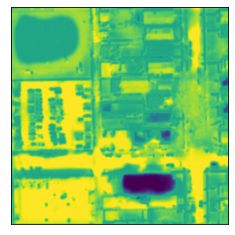

In [34]:
show_image(torch.sigmoid(model.cuda()(X[:2].float().cuda()))[0])

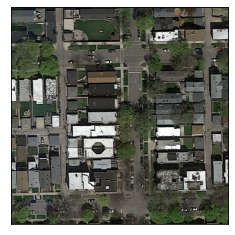

In [35]:
show_image(X[1])

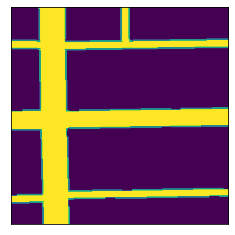

In [29]:
show_image(y[1])

In [30]:
system.visualize_results_overlay()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor